In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from datetime import date, timedelta  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets, linear_model
from sklearn.decomposition import TruncatedSVD
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import unittest
import os



In [2]:
 df = pd.read_feather('C:/Users/asus/Documents/rts27.feather')

In [18]:
class DataReader: 

    def drop_cols(self, data):
        data.drop(['file_name','designated_market_makers','legal_entity_name', 'systematic_internaliser_flag'], axis = 1, inplace = True, errors='ignore')
        return data
    
    def concat_tables(self):
        dfArray = []
        dfArray.append(pd.read_csv('C:/Users/asus/Documents/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20180103_20180331.csv'))
        dfArray.append(pd.read_csv('C:/Users/asus/Documents/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20180401_20180630.csv'))
        dfArray.append(pd.read_csv('C:/Users/asus/Documents/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20180701_20180930.csv'))
        dfArray.append(pd.read_csv('C:/Users/asus/Documents/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20181001_20181231.csv'))
        dfArray.append(pd.read_csv('C:/Users/asus/Documents/RTS27 data/RTS27_NWMS_Table2_FinancialInstrumentIdentification_20190101_20190331.csv'))
        newData = pd.concat(dfArray)
        return newData

    def modify_table_data(self, data):
        newData = self.concat_tables()
        newData = newData.rename(columns={'Financial Instrument Name':'source_instrument_name', 'Instrument Identifier(ISO 6166)':'instrument_identifier'})
        newData = newData[['source_instrument_name','instrument_identifier']].dropna()
        newData.drop_duplicates(subset ='instrument_identifier', keep = 'first', inplace = True) 
        data['source_instrument_name'] = data['instrument_identifier'].map(newData.set_index('instrument_identifier')['source_instrument_name'])
        return df


    def filter_fx_fwrds(self, data):
        #Filters the code to FX forwards only
        dropped_data = self.drop_cols(data)
        flt = dropped_data.loc[(data['instrument_classification']).astype(str).str.contains("JF") | (data['source_instrument_desc']).astype(str).str.contains("Forward") | (data['source_instrument_name']).astype(str).str.contains("Forward")]
        return flt
    
    def get_bank(self, bank_name, data):
        banks = data.groupby(data['bank_name'])
        return banks.get_group(bank_name)

In [9]:
class ForwardsCleaner:
    
    def fill_trans_values(self, df):
        df['total_value_of_trans_gbp'] = df['total_value_of_trans_gbp'].fillna(df['total_value_of_trans_eur']).fillna(df['total_value_of_transactions'])
        return df
    
    def get_IMM_rolls(self, start_date, end_date, data, imm_date):
        rtsQ = data.loc[(data['date_of_trading_day'] > start_date) & (data['date_of_trading_day'] <= end_date) & ((data['source_instrument_desc']).astype(str).str.contains(imm_date) | (data['source_instrument_name']).astype(str).str.contains(imm_date))]
        return rtsQ
    
    def get_roll_quarters(self, dates, data):
        quarters = []
        for q in dates:
            quarters.append(self.get_IMM_rolls(q[0], q[1], data, q[2]))
        return quarters
    
    def get_all_quarters(self, dates, data):
        quarters = self.get_roll_quarters(dates, data)
        full_imm = pd.concat(quarters)
        return full_imm

In [45]:
class MyPipeline:
    
    def predict(self, data, target, m):
        # Select target
        y = data[target]
        # To keep things simple, we'll use only numerical predictors
        X = data.drop([target], axis=1)

        im = SimpleImputer(strategy='mean',missing_values=np.nan)
        y = y.to_numpy().reshape(-1,1)
        y = im.fit_transform(y)
        y = y.flatten()

                # Divide data into training and validation subsets
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                              random_state=0)

        categorical_cols = [col for col in X.columns if X[col].dtype in ['object']]

        # Select numerical columns
        numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]

        # Keep selected columns only
        my_cols = categorical_cols + numerical_cols
        X_train_filtered = X_train[my_cols].copy()
        X_valid_filtered = X_valid[my_cols].copy()

        numerical_transformer = SimpleImputer(strategy='mean',missing_values=np.nan)

        # Preprocessing for categorical data
        categorical_transformer = Pipeline(steps=[
            ('imputer',SimpleImputer(strategy='most_frequent',missing_values=None)),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])

        sc = StandardScaler(with_mean=False)

        # Bundle preprocessing for numerical and categorical data
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ], remainder='passthrough')

        model =  m

        svd = TruncatedSVD(n_components=5)

        # Bundle preprocessing and modeling code in a pipeline
        my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('scaler', sc),
                                      ('svd', svd) ,
                                      ('model', model)
                                     ])

        # Preprocessing of training data, fit model 
        my_pipeline.fit(X_train_filtered, y_train)

        # Preprocessing of validation data, get predictions
        preds = my_pipeline.predict(X_valid_filtered)

        return preds.flatten(), X_valid, y
    
    
    def plot_preds(self, data, target, m):
        preds = self.predict(data, target, m)[0]
        x_val = self.predict(data, target, m)[1]
        
        fig, ax = plt.subplots(figsize = (12,6))
        sns.lineplot(x = x_val['date_of_trading_day'], y = preds, estimator = sum, ci = None ,ax=ax, label='predicted')
        #fig, ax2 = plt.subplots(figsize = (12,6))
        sns.lineplot(x = x_val['date_of_trading_day'], y = data['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax, label='actual')

        x_dates = data['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
        ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
        #ax2.set_xticklabels(labels=x_dates, rotation=45, ha='right')
        
    def calculate_error(self, data, target, m):
        preds = self.predict(data, target, m)[0]

In [33]:
data_reader = DataReader()
fwrds_cleaner = ForwardsCleaner()

merged_data = data_reader.modify_table_data(df)
fx_fwrds = data_reader.filter_fx_fwrds(merged_data)
clean_fx_fwrds = fwrds_cleaner.fill_trans_values(fx_fwrds)
dates = [['2018-03-07', '2018-03-28',"20180620"], 
         ['2018-06-06', '2018-06-27', "20180919"],
         ['2018-09-05', '2018-09-26', "20181219"],
         ['2018-12-05', '2018-12-26', "20190320"]]

fx_rolls = fwrds_cleaner.get_all_quarters(dates, clean_fx_fwrds)
fx_rolls.head(5)

<ipython-input-9-6ce5966cdaff>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_value_of_trans_gbp'] = df['total_value_of_trans_gbp'].fillna(df['total_value_of_trans_eur']).fillna(df['total_value_of_transactions'])


,id,bank_name,date_of_trading_day,instrument_identifier,instrument_classification,order_request_quotes_received,executed_transactions,total_value_of_transactions,order_request_quotes_can_wdrwn,order_request_quotes_modified,...,median_transaction_size_eur,median_transaction_size_gbp,median_size_request_quotes_eur,median_size_request_quotes_gbp,smartie_instrument_name,data_quality_flag,egb_eligible_flag,year_quarter,business,central_bank_isin_flag
5219,7201509,HSBC,2018-03-28,EZ4BH61JGHV3,None,6.0,0.0,0.0,6.0,0.0,...,0.0,0.000000,1.141891e+06,1.000000e+06,None,None,None,2018 Q1,None,None
7888,7173565,HSBC,2018-03-23,EZ97W6R9R8B9,None,2.0,2.0,100000.0,0.0,0.0,...,50000.0,43659.009168,5.000000e+04,4.365901e+04,None,None,None,2018 Q1,None,None
9723,6679050,HSBC,2018-03-16,EZ2L6TGX76N5,None,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000e+00,None,None,None,2018 Q1,None,None
9743,6679074,HSBC,2018-03-16,EZ3T5W5YBHM6,None,1.0,0.0,0.0,1.0,0.0,...,0.0,0.000000,0.000000e+00,0.000000e+00,None,None,None,2018 Q1,None,None
12483,6678481,HSBC,2018-03-14,EZ51B42LC8K0,None,6.0,0.0,0.0,6.0,0.0,...,0.0,0.000000,2.247768e+07,1.992826e+07,None,None,None,2018 Q1,None,None


In [34]:
fx_rolls.reset_index(drop=True).to_feather('C:/Users/asus/Documents/RTS27filtered.feather')

In [35]:
reducedRTS = pd.read_feather("C:/Users/asus/Documents/RTS27filtered.feather")

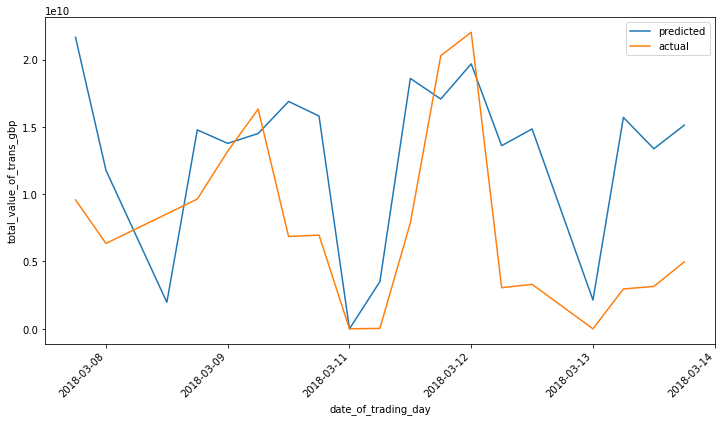

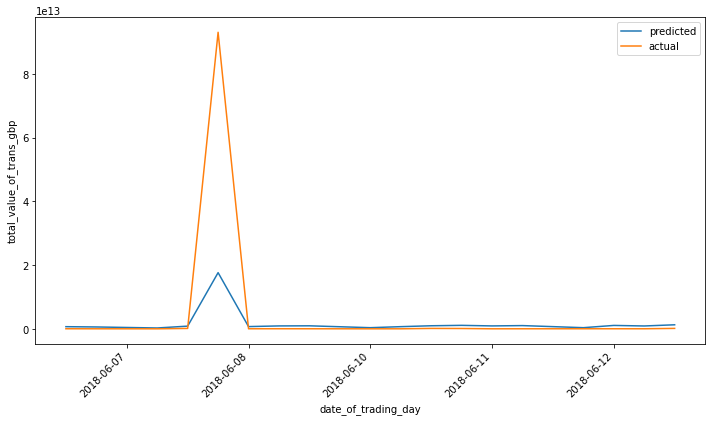

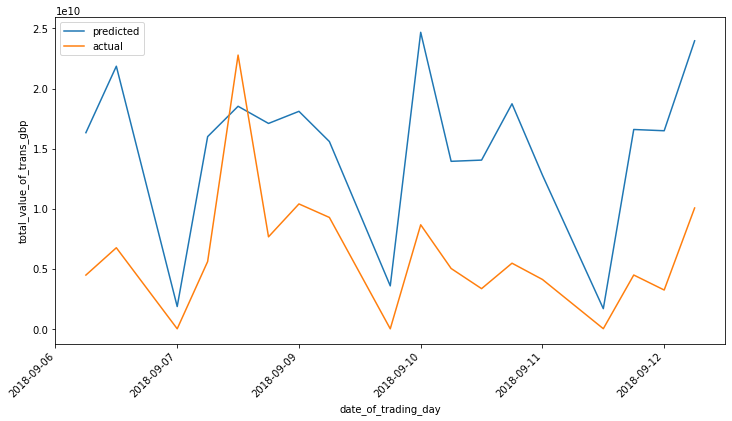

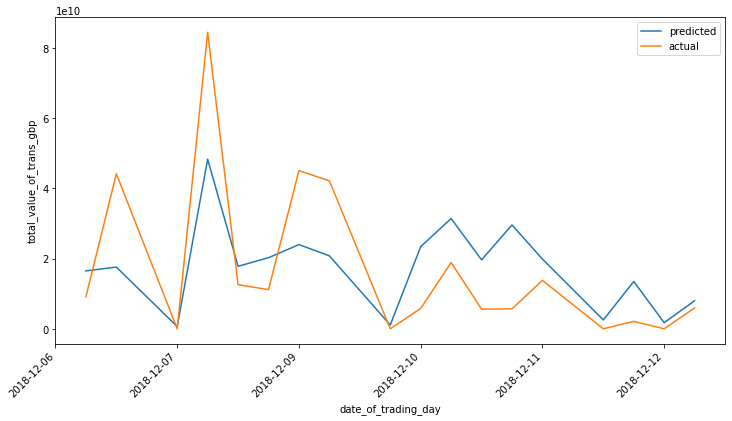

In [46]:
#q1 = fwrds_cleaner.get_roll_quarters(dates, reducedRTS)[1]
pipeline = MyPipeline()

#print(fwrds_cleaner.get_roll_quarters(dates, reducedRTS)[1].shape)

for q in fwrds_cleaner.get_roll_quarters(dates, reducedRTS):
    #print(q.shape)
    model = RandomForestRegressor(n_estimators=50, random_state=0)
    pipeline.plot_preds(q, 'total_value_of_trans_gbp', model)

In [ ]:
q1 = fwrds_cleaner.get_roll_quarters(dates, reducedRTS)[1]
banks = q1.groupby(reducedRTS['bank_name'])

for i, bank in banks:
    fig, ax = plt.subplots(figsize = (12,6))
    sns.barplot(x = bank['date_of_trading_day'], y = bank['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax, hue = bank['bank_name'])
    x_dates = q1['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

plt.show()

In [ ]:
sns.set(style="ticks", color_codes=True) 

g = sns.pairplot(X_train)

In [ ]:
HSBC_Q1 = data_reader.get_bank('HSBC',q1)
HSBC_Q1.head(5)

In [ ]:
preds = preds.flatten()
print(preds.shape)


fig, ax = plt.subplots(figsize = (12,6))
sns.barplot(x = X_valid['date_of_trading_day'], y = preds, estimator = sum, ci = None ,ax=ax)
fig, ax2 = plt.subplots(figsize = (12,6))
sns.barplot(x = X_valid['date_of_trading_day'], y = HSBC_Q1['total_value_of_trans_gbp'], estimator = sum, ci = None ,ax=ax2)

x_dates = q1['date_of_trading_day'] .dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax2.set_xticklabels(labels=x_dates, rotation=45, ha='right')

In [ ]:
TESTDATA_FILENAME = 'C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/rts27.feather'
dfTest = pd.read_feather('C:/Users/inald/Documents/NWMprod/wetransfer-0f4d76/rts27.feather')

In [ ]:
class TestNotebook(unittest.TestCase):
    
    
    def test_add(self):
        self.assertEqual(4,4)

    #checks that the dataframes contain frames
    def test_data_read(self):
        if dfTest.empty:
            self.assertTrue(False)
        else:
            self.assertTrue(True)
    
    #Test to check that columns are disposed of that are not needed        
    def test_dropping_columns(self):
        dropped_df = dfTest.drop(['date_created', 'instrument_identifier'], axis=1)
        Xtest = dropped_df
        count = 0
        count2 = 0
        for col in dfTest.columns:
            count = count + 1
        for col in Xtest.columns:
            count2 = count + 1
        self.assertNotEqual(count, count2)
        
   #Test to check that the train data is larger than the test - test the 80% v 20% difference    
    def test_splitting_data_size(self):
        Xtest = dfTest.drop(['date_created', 'instrument_identifier'], axis=1)
        ytest = dfTest['date_created']
        Xtest_train, Xtest_valid, ytest_train, ytest_valid = train_test_split(Xtest, ytest, train_size=0.8, test_size=0.2, random_state=0)
        if Xtest_train.size > Xtest_valid.size:
            self.assertTrue(True)
        else:
            self.assertTrue(False)
    
    unittest.main(argv=[''], verbosity=3, exit=False)
   